# Defining a target

## Goal
Imagine that we can perfectly predict `a certain` target. Can we come out with a trading strategy based on this model? How often and accurate do our models need to be able to do this?
* This is the quantity that we want to predict: (S1.pct_change()+1).shift(-2) = S1.pct_change().shift(-2)+1
* Its equivalent to predicting S1.pct_change().shift(-2)

In [1]:
cd ~/Desktop/MyProjects/moneyManager/

/Users/lduque/Desktop/myProjects/moneyManager


In [17]:
import pandas as pd
import random
import numpy as np
import datetime as datetime

In [3]:
minutesPerDay = 390

def simulateMultipleStrategies(S1, S2, precision = 80, recall=10, numExperiments=100, sizeExperiment=1*minutesPerDay):
    """ Comment
    """

    S = pd.concat([S1,S2], axis=1).dropna()
    S.columns=['S1', 'S2']
    lenS=len(S)
    experimentStarts = random.choices(range(lenS-sizeExperiment), k=numExperiments)

    endPriceS1=[]
    endPriceS2= []
    endPriceStragegy = []
    movementsStrategy = []
    
    for es in experimentStarts:
        T1=S[es:es+sizeExperiment]['S1']
        T2=S[es:es+sizeExperiment]['S2']
        end1, end2, endStrategy, numMovements = simulateStrategyWithNoisyPredictor(T1, T2, precision, recall)
        endPriceS1.append(end1)
        endPriceS2.append(end2)
        endPriceStragegy.append(endStrategy)
        movementsStrategy.append(numMovements)
    return endPriceS1, endPriceS2, endPriceStragegy, movementsStrategy


def simulateStrategyWithNoisyPredictor(S1, S2, precision, recall):
    """ Comment
    """
    lenS = len(S1)
    I1 = (1+S1.pct_change()).fillna(1).values
    I2 = (1+S2.pct_change()).fillna(1).values
    SymbolMin = ['S1' if I1[i]<I2[i] else 'S2' for i in range(lenS)]
    SymbolMax = ['S1' if I1[i]>I2[i] else 'S2' for i in range(lenS)]
    
    numPredictions = (lenS*recall)//100
    numCorrectPredictions = (numPredictions*precision)//100
    predictionIndexes = random.sample(range(lenS), numPredictions)
    correctPredictionIndexes = predictionIndexes[:numCorrectPredictions]
    wrongPredictionIndexes = predictionIndexes[numCorrectPredictions:]
        
    SymbolStrategy = [None]*lenS
    for goodIndex in correctPredictionIndexes: SymbolStrategy[goodIndex]=SymbolMax[goodIndex] 
    for badIndex in wrongPredictionIndexes: SymbolStrategy[badIndex]=SymbolMin[badIndex]
    SymbolStrategy[0] = random.choice(['S1','S2']) if  SymbolStrategy[0]==None else SymbolStrategy[0]
    for i in range(1, lenS): SymbolStrategy[i]=SymbolStrategy[i-1] if SymbolStrategy[i]==None else SymbolStrategy[i]    
    Strategy = [I1[i] if SymbolStrategy[i]=='S1' else I2[i] for i in range(lenS)]
    
    numMovements = 0
    for i in range(1,lenS): numMovements+=(1 if SymbolStrategy[i]!=SymbolStrategy[i-1] else 0)    
    return np.prod(I1), np.prod(I2), np.prod(Strategy), numMovements
    

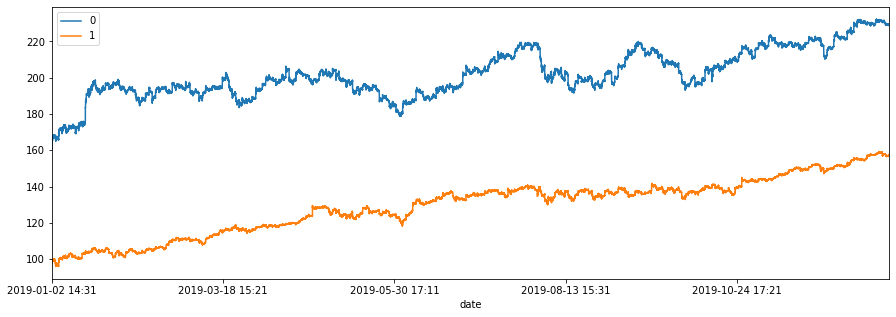

In [4]:
df = pd.read_csv('data/quantopian/minuteIntraday/GS.csv').drop(columns=['volume']).set_index('date')
S1 = df.mean(axis=1)
df = pd.read_csv('data/quantopian/minuteIntraday/MSFT.csv').drop(columns=['volume']).set_index('date')
S2 = df.mean(axis=1)
pd.concat([S1,S2], axis=1).plot(figsize=(15,5))

In [5]:
df

,open_price,high,low,close_price,symbol
date,,,,,
2019-01-02 14:31,98.100,98.149,97.499,97.568,MSFT
2019-01-02 14:32,97.568,97.903,97.508,97.804,MSFT
2019-01-02 14:33,97.824,97.913,97.706,97.775,MSFT
2019-01-02 14:34,97.771,97.942,97.706,97.908,MSFT
2019-01-02 14:35,97.897,98.208,97.893,97.962,MSFT
...,...,...,...,...,...
2019-12-31 20:56,157.610,157.770,157.610,157.705,MSFT
2019-12-31 20:57,157.705,157.740,157.600,157.610,MSFT
2019-12-31 20:58,157.610,157.660,157.570,157.610,MSFT


In [6]:
endStock1, endStock2, endStrategy, movementsStrategy = simulateMultipleStrategies(S1, S2, precision = 70, recall=10, numExperiments=200, sizeExperiment=20*390)

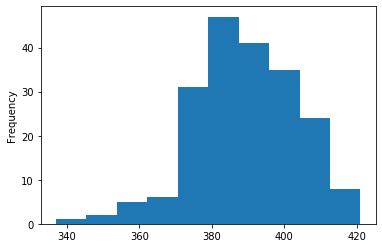

In [7]:
pd.Series(movementsStrategy).plot.hist()

In [8]:
dr=pd.DataFrame({'endStock1':endStock1, 'endStock2':endStock2, 'endStrategy':endStrategy})

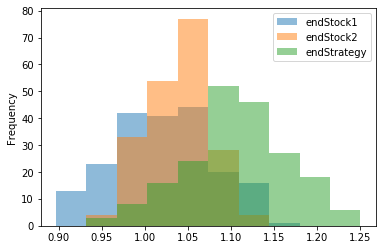

In [9]:
dr.plot.hist(bins=10, alpha=0.5)

In [10]:
dr['bestStock']=dr[['endStock1', 'endStock2']].max(axis=1)

In [11]:
dr['difference']=dr.endStrategy-dr.bestStock

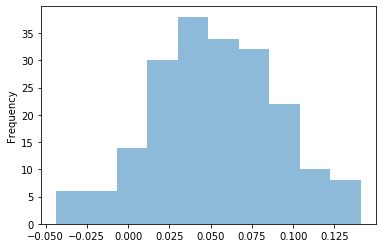

In [12]:
dr.difference.plot.hist(bins=10, alpha=0.5)

In [13]:
dr.difference.describe()

count    200.000000
mean       0.052453
std        0.038136
min       -0.043569
25%        0.025773
50%        0.052247
75%        0.076739
max        0.140771
Name: difference, dtype: float64

In [14]:
dr.endStrategy


0      1.145755
1      1.130643
2      1.076458
3      1.044961
4      1.119157
         ...   
195    1.085669
196    1.113765
197    1.087672
198    0.962818
199    1.096958
Name: endStrategy, Length: 200, dtype: float64

In [15]:
df[df.bigVolume].target.value_counts().plot.bar()

AttributeError: 'DataFrame' object has no attribute 'bigVolume'

In [ ]:
df[df.bigVolume].target.value_counts()

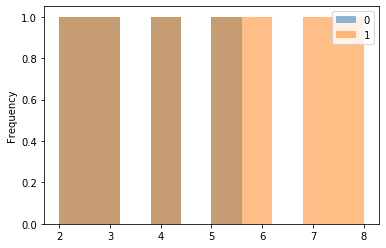

In [16]:
s1=pd.Series([2,3,4,5])
s2=pd.Series([2,3,4,5,6,7,8])
pd.concat([s1,s2], ignore_index=True, axis=1).plot.hist(bins=10, alpha=0.5)